あるストリーミングサービスの解約率を調べるという状況を想定する  
まずはデータ生成を行う  

ここで解約率を推定するために利用できるデータは以下のものとする。

| 項目 | 説明 | 分布 | コメント |
| --- | --- | --- | --- |
| DaysSinceLastActivity | 最終ログインからの日数 | 指数分布: 平均10日 | 幽霊アカウントを含めたらこんな感じか？
| HasActivePromotionalOffer | 復帰を促したか | 二項分布: 0 or 1 | -- |
| AverageSessionDuration | 平均セッション時間 | ガンマ分布: (2,15) 平均30分 | 大体の通学時間を想定

In [156]:
using Random

Random.seed!(1234)
n_samples = 1000

1000

10-element Vector{Float64}:
  3.989805872320786
 10.97157487488112
 11.528800883195558
  0.32182180836827007
  9.852672831588938
 14.861479297186445
 44.69383545607664
  3.138659888253987
 10.057130392898497
 16.665226566676623

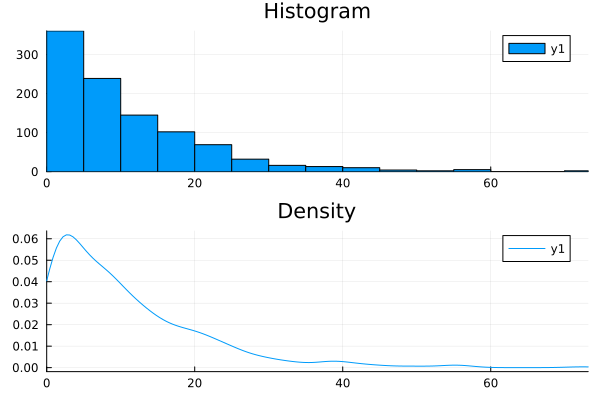

In [157]:
using Distributions
using StatsPlots

DaysSinceLastActivity = rand(Exponential(10), n_samples)
display(first(DaysSinceLastActivity, 10))

xlims_DSA=(0, maximum(DaysSinceLastActivity))
plot(
    histogram(
        DaysSinceLastActivity,
        title="Histogram",
        xlims=xlims_DSA
    ),
    density(
        DaysSinceLastActivity,
        title="Density",
        xlims=xlims_DSA
    ),
    layout=(2,1),
)

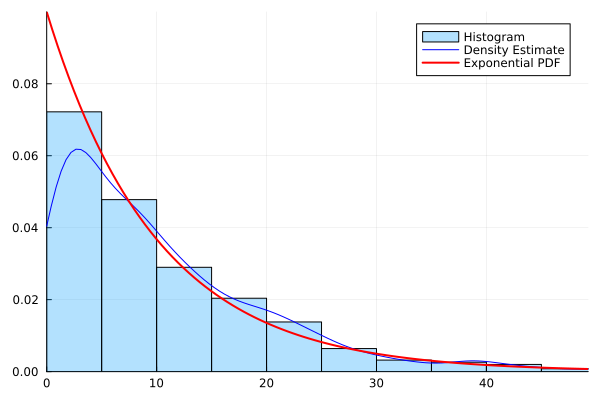

In [158]:
# Combined Histogram and Density plot on the same plot
plots_DaysSinceLastActivity = histogram(
    DaysSinceLastActivity,
    bins=30,
    normalize=true,   # Crucial for density plot
    fillalpha = 0.3,
    linecolor = :black,
    label = "Histogram",
    xlims = (0, quantile(DaysSinceLastActivity, 0.99))
)
density!(
    DaysSinceLastActivity,
    fillalpha = 0.6,
    linecolor = :blue,
    label = "Density Estimate",
)
# 指数関数の確率密度関数
x = range(0, quantile(DaysSinceLastActivity, 0.99), length=100)
plot!(
    x,
    pdf(Exponential(10), x),
    linewidth=2,
    color=:red,
    label="Exponential PDF"
)
display(plots_DaysSinceLastActivity)


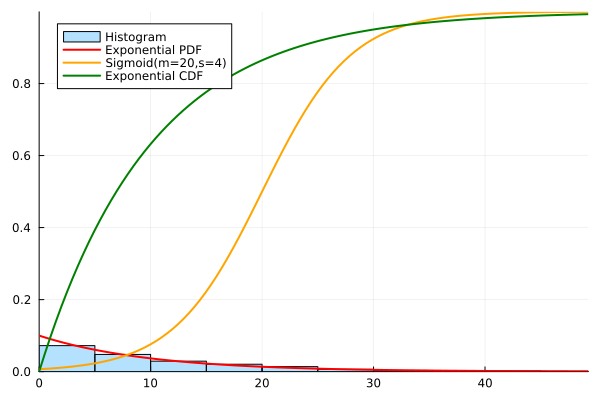

In [159]:
histogram(
    DaysSinceLastActivity,
    bins=30,
    normalize=true,   # Crucial for density plot
    fillalpha = 0.3,
    linecolor = :black,
    label = "Histogram",
    xlims = (0, quantile(DaysSinceLastActivity, 0.99))
)
plot!(
    x,
    pdf(Exponential(10), x),
    linewidth=2,
    color=:red,
    label="Exponential PDF"
)
sigmoid(x, m, s) = 1 ./ (1 .+ exp.(-(x .- m) ./ s))
plot!(
    x,
    sigmoid(x, 20, 4),
    linewidth=2,
    color=:orange,
    label="Sigmoid(m=20,s=4)"
)
plot!(
    x,
    cdf(Exponential(10), x),
    linewidth=2,
    color=:green,
    label="Exponential CDF"
)

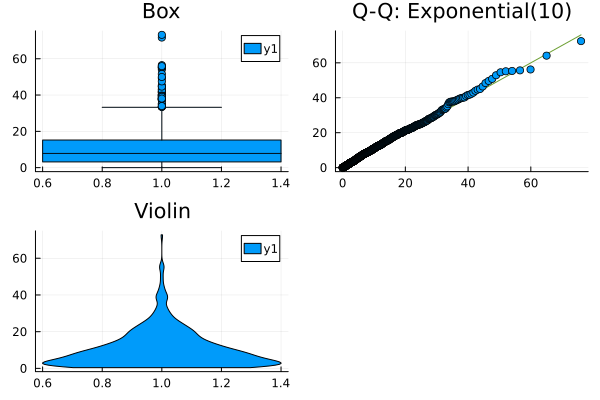

In [160]:
# その他のプロットたち
plot(
    boxplot(
        DaysSinceLastActivity,
        title="Box"
    ),
    qqplot(
        Exponential(10),
        DaysSinceLastActivity,
        title="Q-Q: Exponential(10)",
    ),
    violin(
        DaysSinceLastActivity,
        title="Violin"
    )
)

5-element Vector{Int64}:
 0
 1
 1
 0
 0

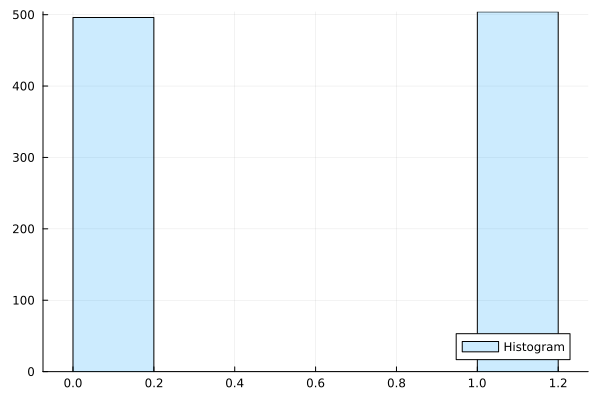

In [161]:
# 次はHasActivePromotionalOffer
HasActivePromotionalOffer = rand([0,1], n_samples)
display(first(HasActivePromotionalOffer, 5))
plots_HasActivePromotionalOffer = histogram(
    HasActivePromotionalOffer,
    fillalpha=0.2,
    label="Histogram"
)
display(plots_HasActivePromotionalOffer)

In [162]:
# AverageSessionDuration
# これはガンマ分布(2,15)
AverageSessionDuration = rand(Gamma(2,15), n_samples)
display(first(AverageSessionDuration, 5))

5-element Vector{Float64}:
 39.26013305811533
 63.38556973255818
 29.298779615357244
 37.88617281099633
 59.433326040070746

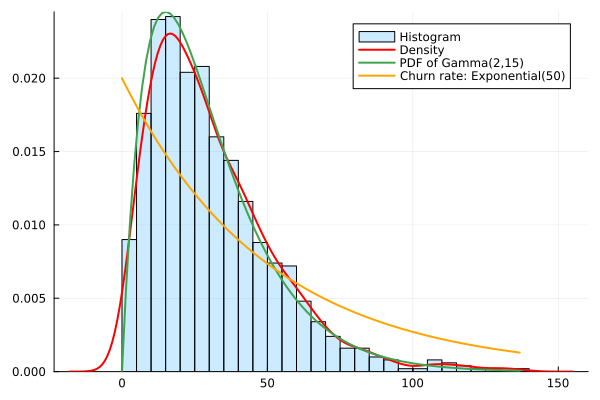

In [163]:
# density & ガンマ分布のpdfも併記
plots_AverageSessionDuration = histogram(
    AverageSessionDuration,
    normalize=true,
    fillalpha=0.2,
    label="Histogram",
)
density!(
    AverageSessionDuration,
    label="Density",
    color="red",
    linewidth=2
)
x = range(0, maximum(AverageSessionDuration), length=100)
plot!(
    x,
    pdf(Gamma(2,15), x),
    label="PDF of Gamma(2,15)",
    linewidth=2
)
lambda = 50
plot!(
    x,
    pdf(Exponential(lambda), x),
    color="orange",
    linewidth=2,
    label="Churn rate: Exponential($lambda)"
)
display(plots_AverageSessionDuration)

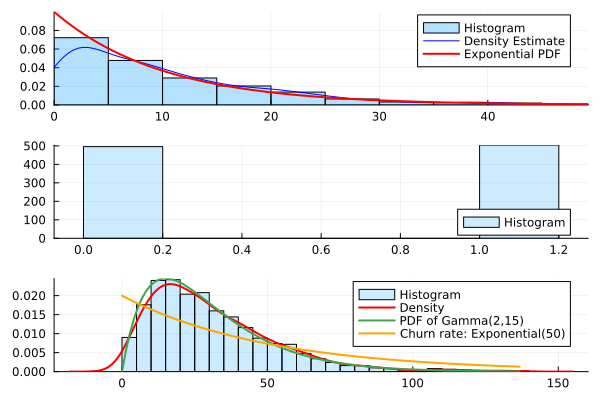

In [164]:
# 3つを並べて表示
plot(
    plots_DaysSinceLastActivity,
    plots_HasActivePromotionalOffer,
    plots_AverageSessionDuration,
    layout=(3,1)
)


# 解約についてのユーザー設定
解約グループと、そうではない通常グループについての設定（振る舞い）を定義する。

# 最終ログインからの時間 (DaysSinceLastActivity)
- DaysSinceLastActivityは指数分布に従うデータ
- 最終ログインからの時間が長いほど解約率が上がる
- 解約率はシグモイド間数でモデル化
  - 変動させるのは中間パラメータmのみ
  - スケールパラメータmの変更は行わない
## 解約グループ
- 解約グループは解約までの判断が早いと想定
- このユーザは見切りが早く、あっさりと他のサービスに乗り換えてしまう
- 通常m=20のところ、このグループの閾値はm=10とする

# プロモーション (HasActivePromotionalOffer)
- HasActivePromotionalOfferは、行うか行わないかのベルヌーイ分布(0.5)
- プロモーション実施はコストの問題のため全員に行うことはできず、実施確率は５０％となっている
## 解約グループ
- プロモーションは実際効果的であった
- 実際、解約グループはプロモーションを全体で２割しか受け取っていない

# セッション時間 (AverageSessionDuration)
- AverageSessionDurationgはガンマ分布に従うデータ
- おおよそこのサービスは平均的に３０分再生されている
- そして解約率は平均再生時間に比例して下がる
  - つまり解約率は平均再生時間の指数分布とモデル化できる
  - 指数関数のlambdaを変更することで解約の度合いを変えられる
## 解約グループ
- 解約グループは平均再生時間が仮に長かったとしても、あっさりと解約を行なってしまう
- 通常が平均５０に対し、解約グループは１０
  - 解約グループは見切りを付けるのが速い
  - 再生時間が短い場合、解約をすることをためらわない

In [165]:
# データの作成は完了
# 次は解約率の設定とそのラベルの作成

labels = zeros(Int, n_samples)

p_churn = 0.1

# 解約をシミュレーションしてラベル作成
for i=1:n_samples
    churn_influence = p_churn *
        sigmoid(DaysSinceLastActivity[i], 15, 4) *
        pdf(Bernoulli(0.2), HasActivePromotionalOffer[i]) *
        pdf(Exponential(20), AverageSessionDuration[i])
    no_churn_influence = (1 - p_churn) *
        sigmoid(DaysSinceLastActivity[i], 20, 4) *
        pdf(Bernoulli(0.4), HasActivePromotionalOffer[i]) *
        pdf(Exponential(50), AverageSessionDuration[i])
    influence_norm = churn_influence / (churn_influence + no_churn_influence)
    labels[i] = rand() < influence_norm ? 1 : 0
    println(DaysSinceLastActivity[i], '\t', HasActivePromotionalOffer[i], '\t', AverageSessionDuration[i])
    println("P$i:\t", influence_norm)
end

println("Average churn: $(mean(labels))")

3.989805872320786	0	39.26013305811533
P1:	0.275924926285581
10.97157487488112	1	63.38556973255818
P2:	0.055332507105431944
11.528800883195558	1	29.298779615357244
P3:	0.13704894538854967
0.32182180836827007	0	37.88617281099633
P4:	0.28951726682616513
9.852672831588938	0	59.433326040070746
P5:	0.15525681968285965
14.861479297186445	1	41.39915852998937
P6:	0.08334689863118994
44.69383545607664	1	32.24373920531192
P7:	0.050215648570267474
3.138659888253987	0	25.04317709395092
P8:	0.3704827231840458
10.057130392898497	1	26.82497734562342
P9:	0.15394649418943812
16.665226566676623	0	64.12599349963237
P10:	0.0971705870301769
12.878688642247445	0	39.18241357891025
P11:	0.22694066947456218
9.094206985521332	1	9.034680565909342
P12:	0.2427843980456176
15.468796489015496	1	23.691985750365184
P13:	0.12908655686651924
0.9872417191708115	1	26.822562713564498
P14:	0.17511113937360584
16.30821212649176	0	44.16117532961387
P15:	0.16749342118769833
13.06411575515921	0	20.788937052116705
P16:	0.33526544

0	4.0178367504744665
P161:	0.5283245855849708
1.5044689994929188	1	29.04562492111826
P162:	0.16529236716352474
7.319245344735092	0	30.75595219350533
P163:	0.3183042972881769
7.181072505710345	1	14.829615048481251
P164:	0.22069274085589036
0.9092807560001036	1	23.715964358570023
P165:	0.18904450288540908
11.992686805918225	0	37.35097419442917
P166:	0.24538939148559985
54.093373437166704	0	7.993058449023177
P167:	0.22567396033637832
3.2084529004548012	1	11.125867552913979
P168:	0.2508540118976679
0.18104531796657897	0	42.654032148089996
P169:	0.2611198311665783
6.385534660468032	0	47.81603822736986
P170:	0.22186534335954566
22.34811363587983	1	3.0660141288281304
P171:	0.1453228925424462
2.943539906985304	0	9.502226973822257
P172:	0.4844363609347368
5.344383076577267	0	28.651279838410716
P173:	0.3400283314267153
2.98064483760351	1	18.361460640776915
P174:	0.21262280757103086
2.899859000987162	0	31.198201814657118
P175:	0.32898127006336464
5.857922110814301	0	7.0051554705362005
P176:	0.494